<a href="https://colab.research.google.com/github/itsshaikaslam/ARPC-Conf-Yves-Hilpisch/blob/master/time_series_covid_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Coronavirus Daily Cases Forecasting with LSTMs using PyTorch in Python 

Time series data captures a series of data points captured at (usually) regular intervals. Some common examples include daily weather temperature, stock prices, and the number of Coronavirus cases.

Many classical methods (e.g. ARIMA) try to deal with Time Series data with varying success (not to say they are bad at it). In the last couple of years, [Long Short Term Memory Networks (LSTM)](https://en.wikipedia.org/wiki/Long_short-term_memory) models have become a very useful method when doing Time Series analysis.

Those types of networks are very good at processing sequences of data. They can "recall" patterns in the data that are very far into the past (or future). In this tutorial, you're going to learn how to use LSTMs to predict future Coronavirus cases based on real-world data.

## Novel Coronavirus (COVID-19)

Many cases are currently not reported due to:

- A person can get infected without even knowing (asymptomatic)
- Incorrect data reporting
- Not enough test kits
- The symptoms look a lot like the common flu

In [0]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters

from torch import nn, optim

import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [0]:
!wget https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv

--2020-03-03 19:56:54--  https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19070 (19K) [text/plain]
Saving to: ‘time_series_19-covid-Confirmed.csv’

time_series_19-covi 100%[===================>]  18.62K  --.-KB/s    in 0.01s   

2020-03-03 19:56:54 (1.86 MB/s) - ‘time_series_19-covid-Confirmed.csv’ saved [19070/19070]



In [0]:
# !gdown --id 1AsfdLrGESCQnRW5rbMz56A1KBc3Fe5aV

## Data exploration

In [0]:
df = pd.read_csv('time_series_19-covid-Confirmed.csv')
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20
0,Anhui,Mainland China,31.8257,117.2264,1,9,15,39,60,70,106,152,200,237,297,340,408,480,530,591,665,733,779,830,860,889,910,934,950,962,973,982,986,987,988,989,989,989,989,989,989,990,990,990,990
1,Beijing,Mainland China,40.1824,116.4142,14,22,36,41,68,80,91,111,114,139,168,191,212,228,253,274,297,315,326,337,342,352,366,372,375,380,381,387,393,395,396,399,399,399,400,400,410,410,411,413,414
2,Chongqing,Mainland China,30.0572,107.8740,6,9,27,57,75,110,132,147,182,211,247,300,337,366,389,411,426,428,468,486,505,518,529,537,544,551,553,555,560,567,572,573,575,576,576,576,576,576,576,576,576
3,Fujian,Mainland China,26.0789,117.9874,1,5,10,18,35,59,80,84,101,120,144,159,179,194,205,215,224,239,250,261,267,272,279,281,285,287,290,292,293,293,293,293,293,293,294,294,296,296,296,296,296
4,Gansu,Mainland China,36.0611,103.8343,0,2,2,4,7,14,19,24,26,29,40,51,55,57,62,62,67,79,83,83,86,87,90,90,90,90,91,91,91,91,91,91,91,91,91,91,91,91,91,91,91


In [0]:
df = df.iloc[:, 4:]

In [0]:
df.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20
0,1,9,15,39,60,70,106,152,200,237,297,340,408,480,530,591,665,733,779,830,860,889,910,934,950,962,973,982,986,987,988,989,989,989,989,989,989,990,990,990,990
1,14,22,36,41,68,80,91,111,114,139,168,191,212,228,253,274,297,315,326,337,342,352,366,372,375,380,381,387,393,395,396,399,399,399,400,400,410,410,411,413,414
2,6,9,27,57,75,110,132,147,182,211,247,300,337,366,389,411,426,428,468,486,505,518,529,537,544,551,553,555,560,567,572,573,575,576,576,576,576,576,576,576,576
3,1,5,10,18,35,59,80,84,101,120,144,159,179,194,205,215,224,239,250,261,267,272,279,281,285,287,290,292,293,293,293,293,293,293,294,294,296,296,296,296,296
4,0,2,2,4,7,14,19,24,26,29,40,51,55,57,62,62,67,79,83,83,86,87,90,90,90,90,91,91,91,91,91,91,91,91,91,91,91,91,91,91,91


Check for missing values

In [0]:
df.isnull().sum()

1/22/20    0
1/23/20    0
1/24/20    0
1/25/20    0
1/26/20    0
1/27/20    0
1/28/20    0
1/29/20    0
1/30/20    0
1/31/20    0
2/1/20     0
2/2/20     0
2/3/20     0
2/4/20     0
2/5/20     0
2/6/20     0
2/7/20     0
2/8/20     0
2/9/20     0
2/10/20    0
2/11/20    0
2/12/20    0
2/13/20    0
2/14/20    0
2/15/20    0
2/16/20    0
2/17/20    0
2/18/20    0
2/19/20    0
2/20/20    0
2/21/20    0
2/22/20    0
2/23/20    0
2/24/20    0
2/25/20    0
2/26/20    0
2/27/20    0
2/28/20    0
2/29/20    0
3/1/20     0
3/2/20     0
dtype: int64

In [0]:
daily_cases = df.sum(axis=0)

In [0]:
daily_cases.index = pd.to_datetime(daily_cases.index)

In [0]:
daily_cases

2020-01-22      555
2020-01-23      653
2020-01-24      941
2020-01-25     1434
2020-01-26     2118
2020-01-27     2927
2020-01-28     5578
2020-01-29     6166
2020-01-30     8234
2020-01-31     9927
2020-02-01    12038
2020-02-02    16787
2020-02-03    19881
2020-02-04    23892
2020-02-05    27636
2020-02-06    30818
2020-02-07    34392
2020-02-08    37121
2020-02-09    40151
2020-02-10    42763
2020-02-11    44803
2020-02-12    45222
2020-02-13    60370
2020-02-14    66887
2020-02-15    69032
2020-02-16    71226
2020-02-17    73260
2020-02-18    75138
2020-02-19    75641
2020-02-20    76199
2020-02-21    76843
2020-02-22    78599
2020-02-23    78985
2020-02-24    79570
2020-02-25    80415
2020-02-26    81397
2020-02-27    82756
2020-02-28    84122
2020-02-29    86013
2020-03-01    88371
2020-03-02    90309
dtype: int64

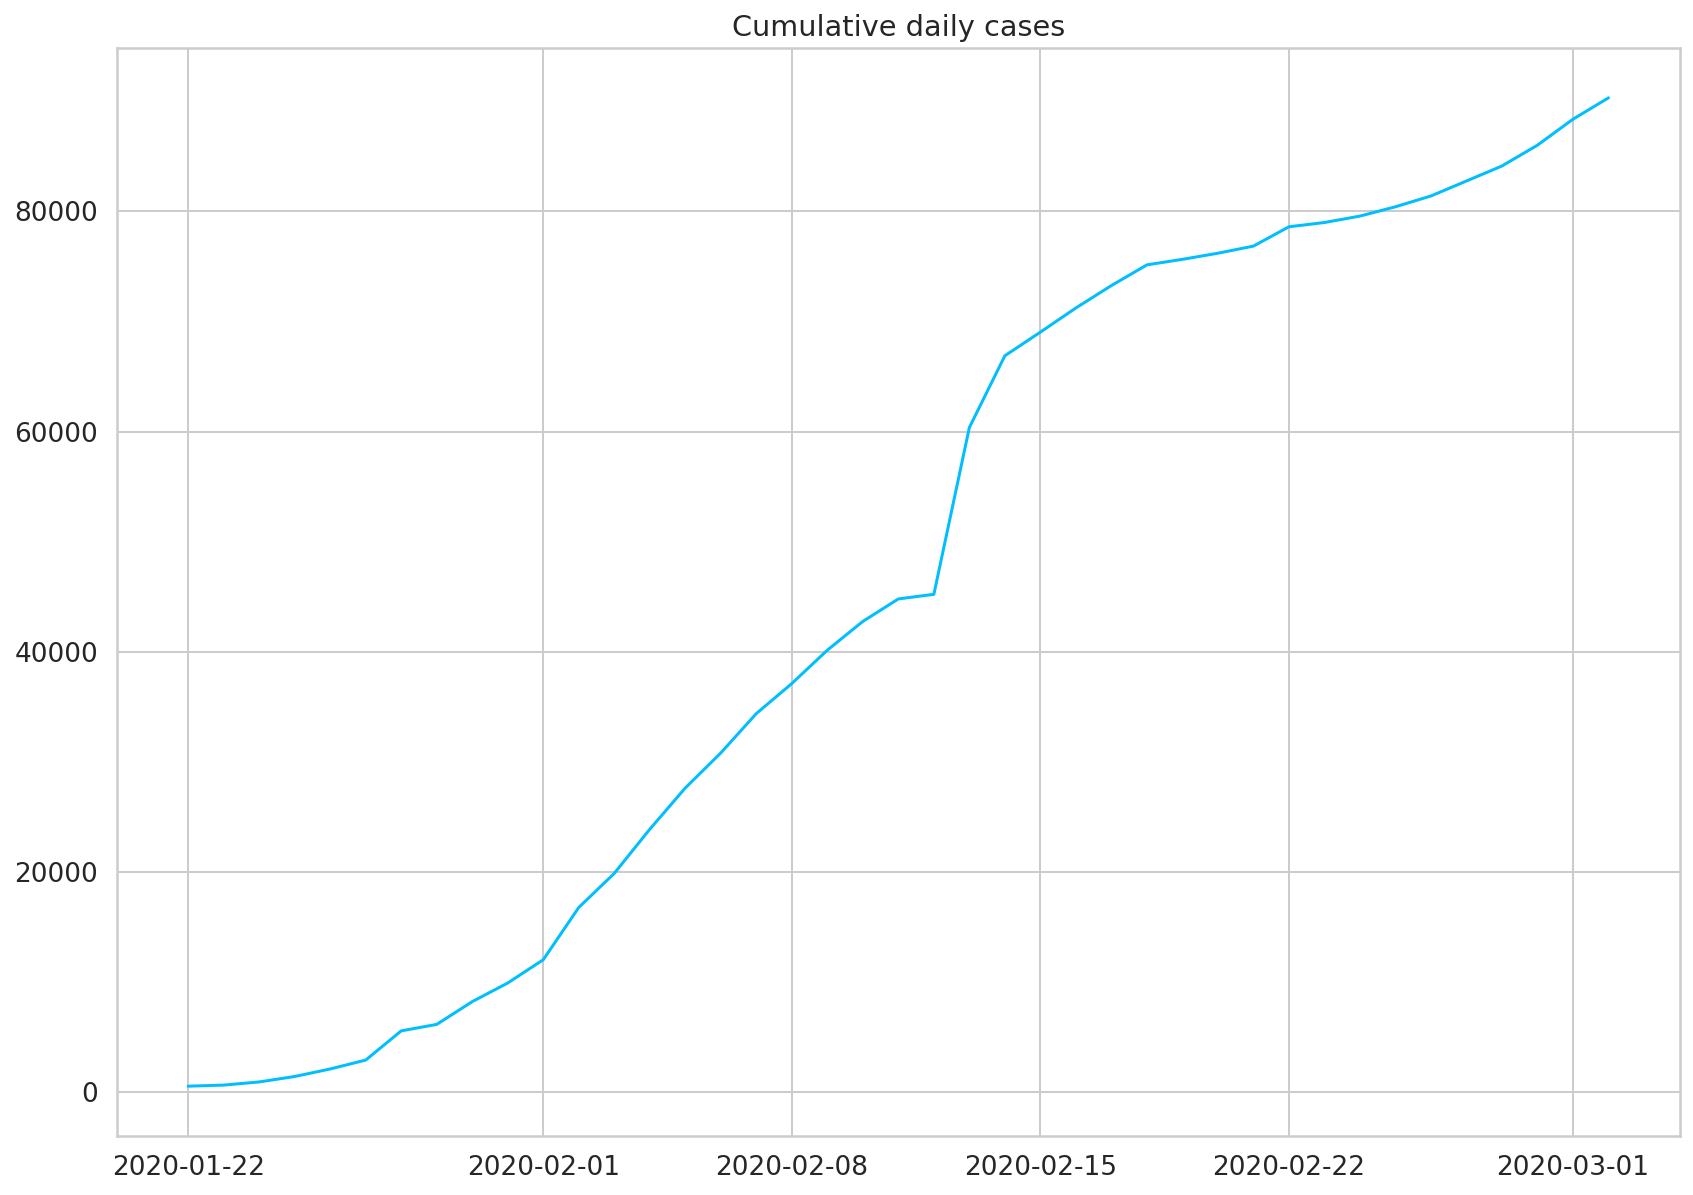

In [0]:
plt.plot(daily_cases)
plt.title("Cumulative daily cases");

In [0]:
daily_cases = daily_cases.diff().fillna(daily_cases[0]).astype(np.int64)

In [0]:
daily_cases.head()

2020-01-22    555
2020-01-23     98
2020-01-24    288
2020-01-25    493
2020-01-26    684
dtype: int64

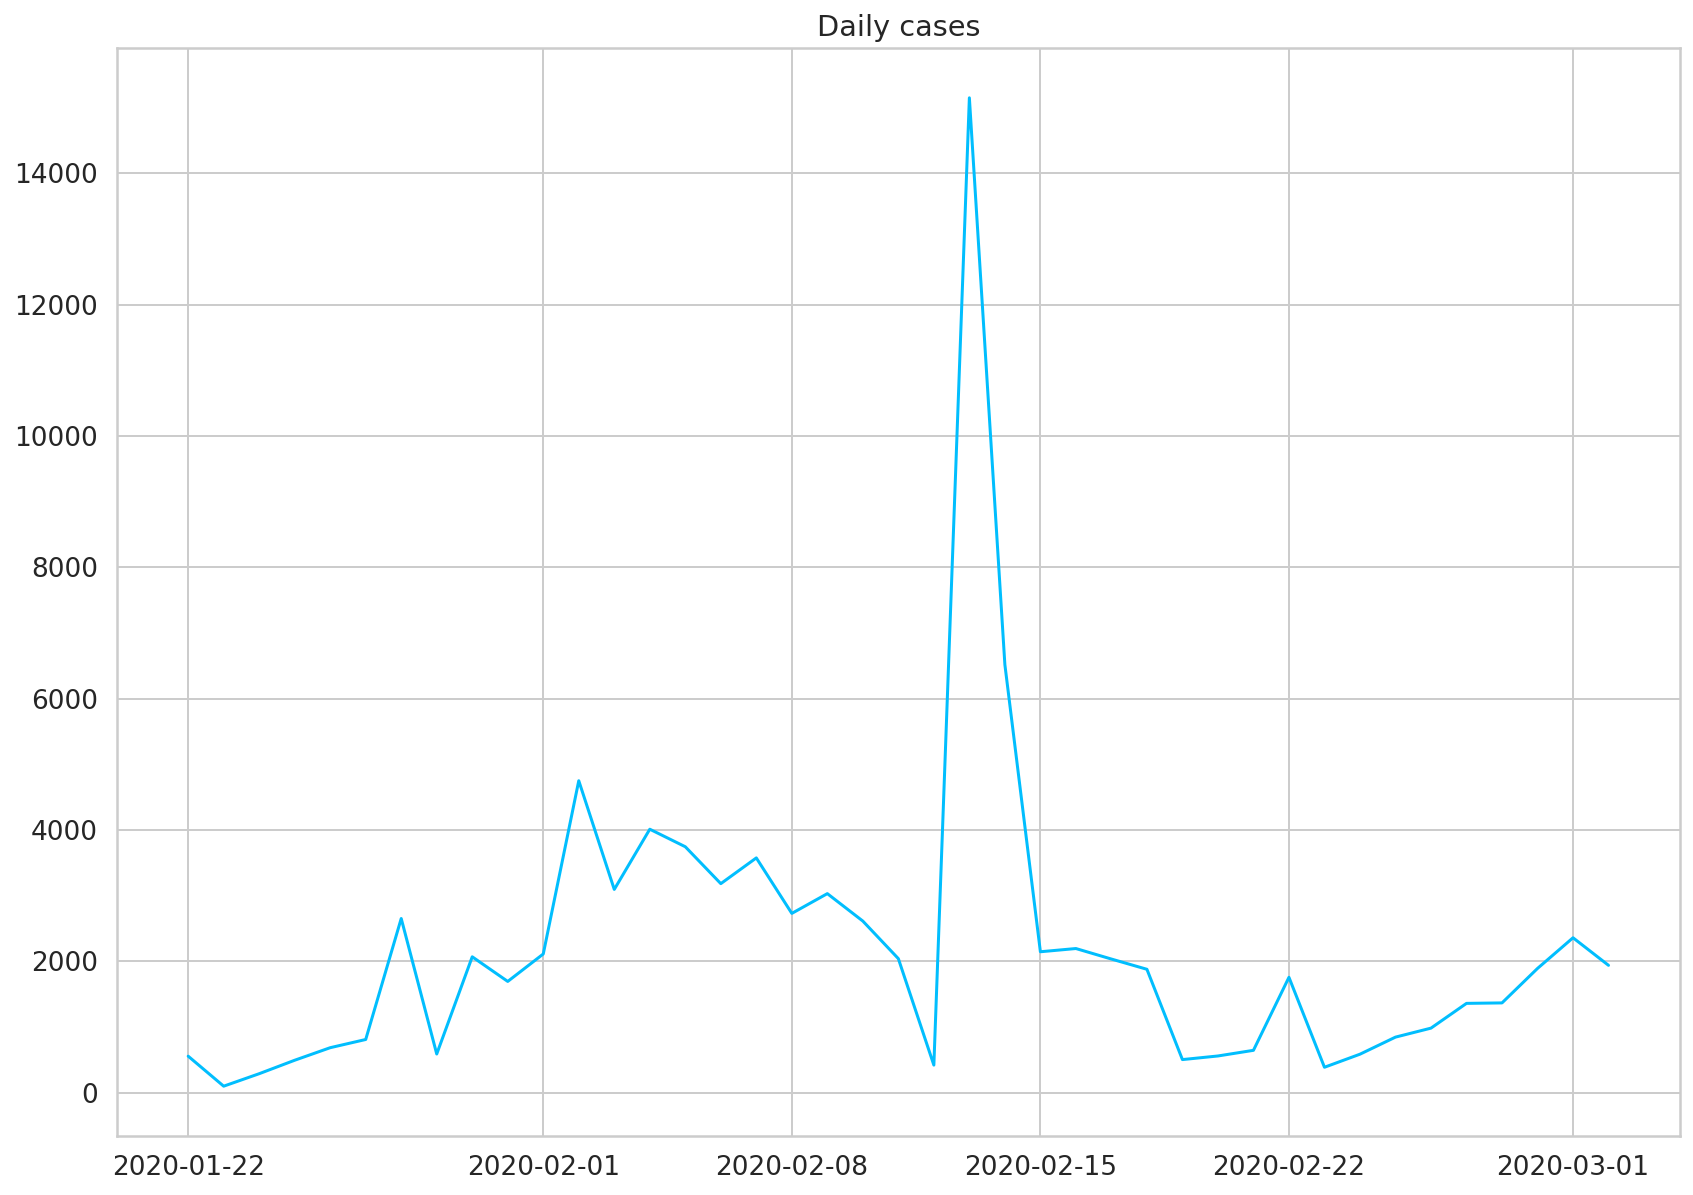

In [0]:
plt.plot(daily_cases)
plt.title("Daily cases");

In [0]:
daily_cases.shape

(41,)

## Preprocessing

In [0]:
test_data_size = 14

train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]

In [0]:
train_data.shape

(27,)

In [0]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(train_data, axis=1))

train_data = scaler.transform(np.expand_dims(train_data, axis=1))

test_data = scaler.transform(np.expand_dims(test_data, axis=1))

In [0]:
def sliding_windows(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [0]:
seq_length = 5
X_train, y_train = sliding_windows(train_data, seq_length)
X_test, y_test = sliding_windows(test_data, seq_length)

In [0]:
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [0]:
X_train.shape

torch.Size([21, 5, 1])

In [0]:
X_train[:2]

tensor([[[0.0304],
         [0.0000],
         [0.0126],
         [0.0262],
         [0.0389]],

        [[0.0000],
         [0.0126],
         [0.0262],
         [0.0389],
         [0.0472]]])

In [0]:
y_train.shape

torch.Size([21, 1])

In [0]:
y_train[:2]

tensor([[0.0472],
        [0.1696]])

In [0]:
train_data[:10]

array([[0.03036545],
       [0.        ],
       [0.01262458],
       [0.02624585],
       [0.03893688],
       [0.04724252],
       [0.16963455],
       [0.03255814],
       [0.13089701],
       [0.10598007]])

## Building a model

In [0]:
class CoronaVirusPredictor(nn.Module):

  def __init__(self, input_dim, hidden_dim, seq_len, num_layers=2):
    super(CoronaVirusPredictor, self).__init__()

    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.seq_len = seq_len
    self.num_layers = num_layers

    self.lstm = nn.LSTM(
      input_size=input_dim, 
      hidden_size=hidden_dim, 
      num_layers=num_layers, 
      dropout=0.5
    )

    self.linear = nn.Linear(in_features=hidden_dim, out_features=1)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.num_layers, self.seq_len, self.hidden_dim),
        torch.zeros(self.num_layers, self.seq_len, self.hidden_dim)
    )

  def forward(self, input):
    lstm_out, self.hidden = self.lstm(
      input.view(len(input), self.seq_len, -1),
      self.hidden
    )
    y_pred = self.linear(
      lstm_out.view(self.seq_len, len(input), self.hidden_dim)[-1]
    )
    return y_pred

## Training

In [0]:
def train_model(model, train_data, train_labels, test_data=None, test_labels=None):
  loss_fn = torch.nn.MSELoss(reduction='sum')

  optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
  num_epochs = 60

  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(num_epochs):
    model.reset_hidden_state()

    y_pred = model(X_train)

    loss = loss_fn(y_pred.float(), y_train)

    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()

      if t % 10 == 0:  
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 10 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()
    
    optimiser.zero_grad()

    loss.backward()

    optimiser.step()
  
  return model.eval(), train_hist, test_hist

In [0]:
model = CoronaVirusPredictor(1, 512, seq_len=seq_length, num_layers=2)
model, train_hist, test_hist = train_model(model, X_train, y_train, X_test, y_test)

Epoch 0 train loss: 1.6297188997268677 test loss: 0.041186608374118805
Epoch 10 train loss: 0.8466923832893372 test loss: 0.12416433542966843
Epoch 20 train loss: 0.821993350982666 test loss: 0.143820121884346
Epoch 30 train loss: 0.8200693130493164 test loss: 0.2190694361925125
Epoch 40 train loss: 0.810839056968689 test loss: 0.1797715425491333
Epoch 50 train loss: 0.7957305312156677 test loss: 0.19855861365795135


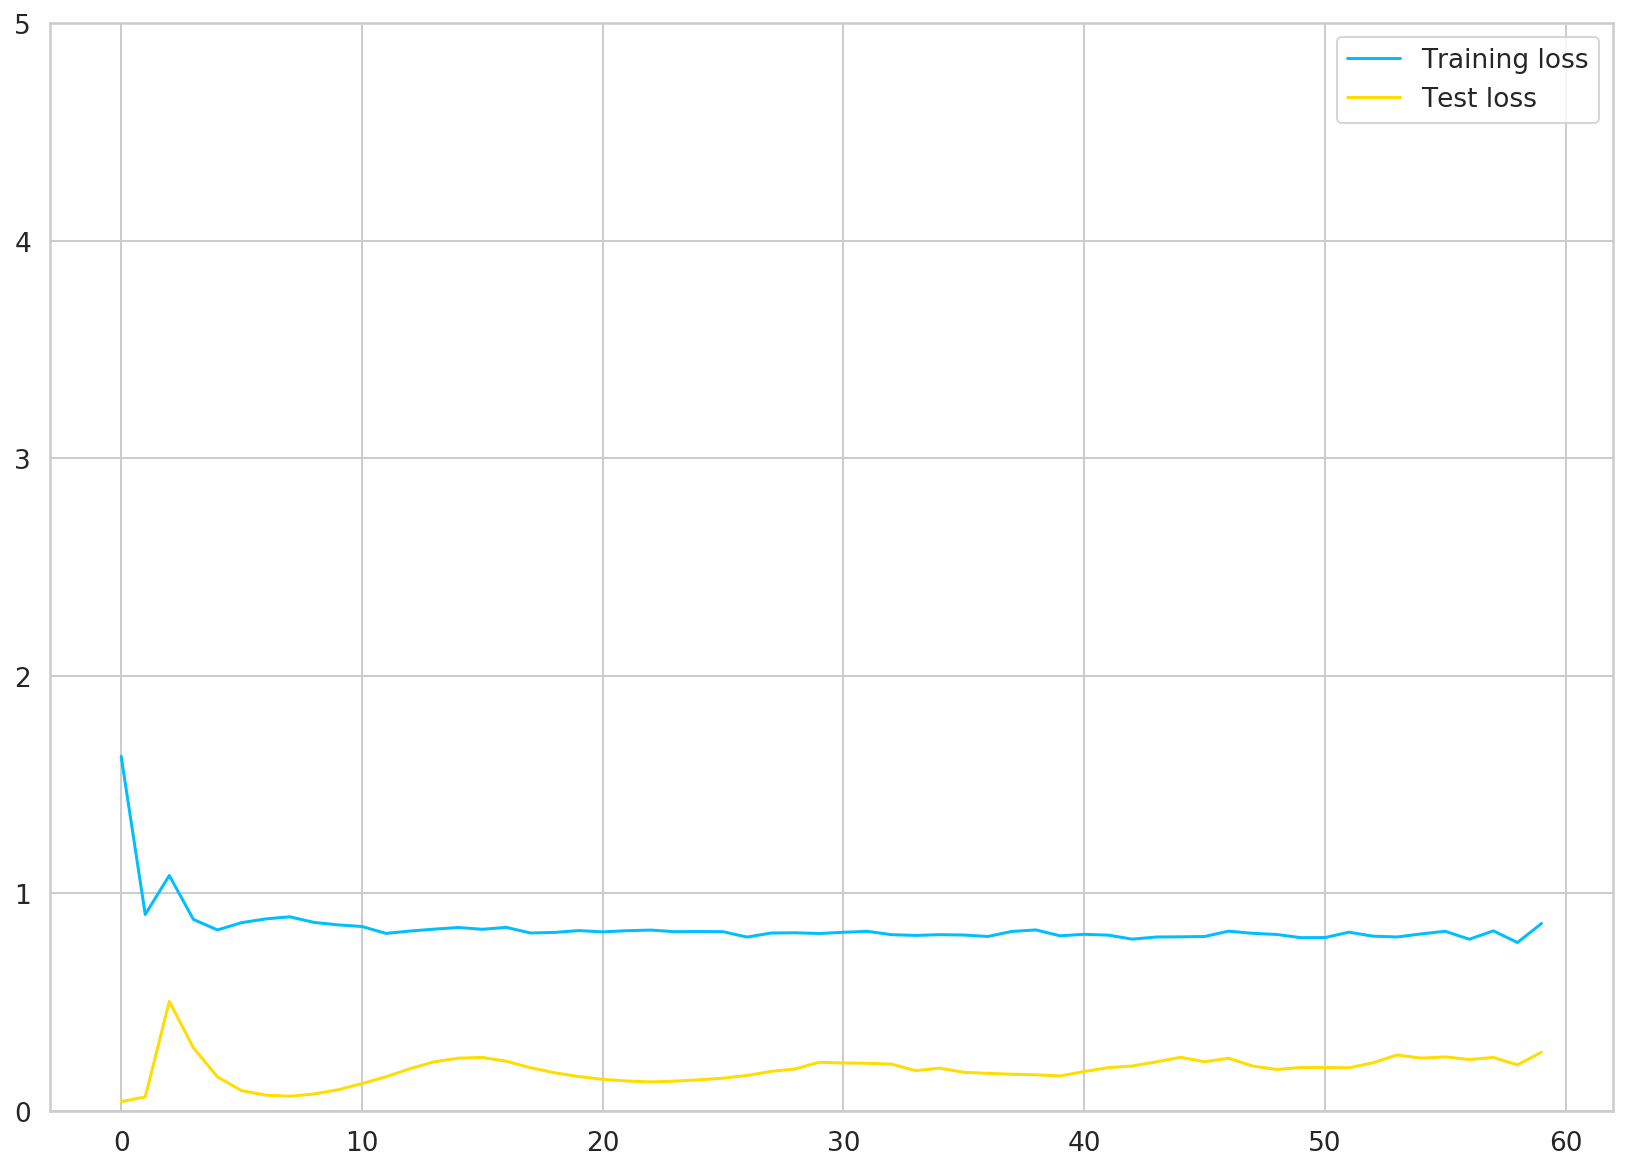

In [0]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.ylim((0, 5))
plt.legend();

## Predicting daily cases

In [0]:
with torch.no_grad():
  test_seq = X_test[:1]
  preds = []
  for _ in range(len(X_test)):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()    
    

In [0]:
true_cases = scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()

In [0]:
predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

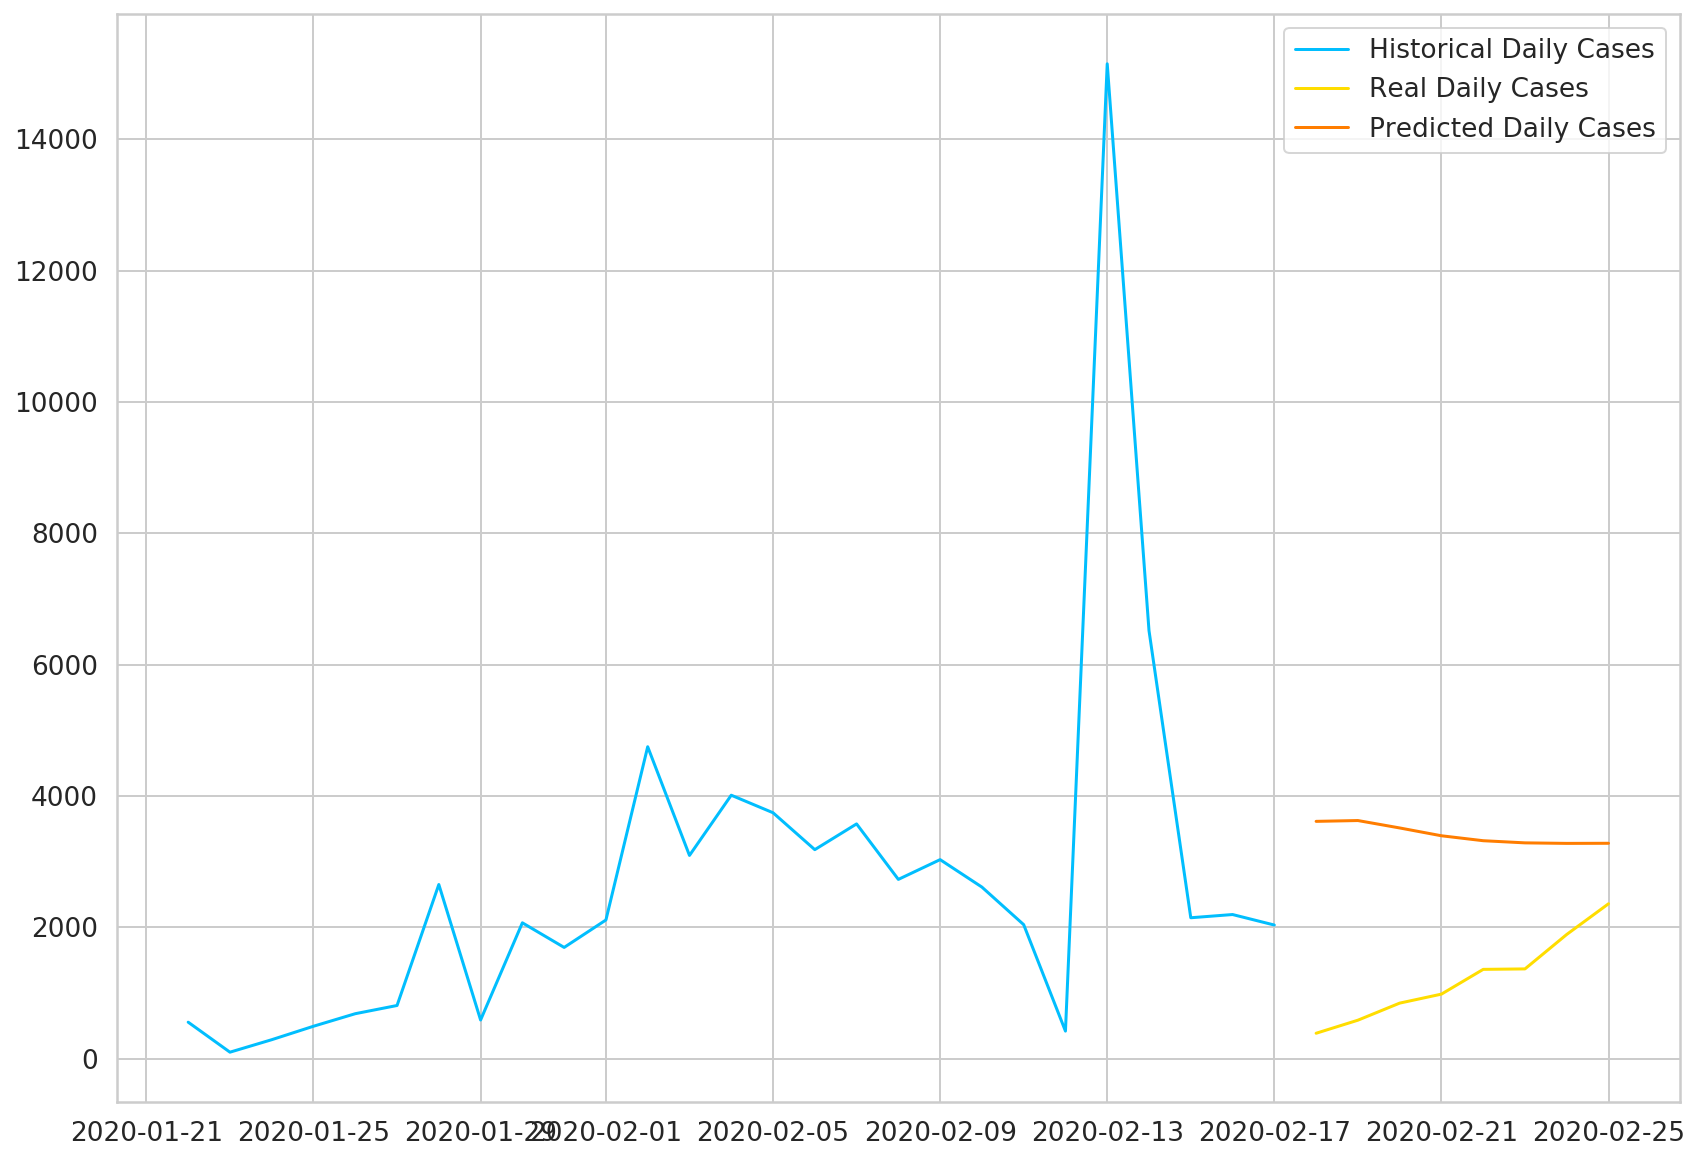

In [0]:
plt.plot(
  daily_cases.index[:len(train_data)], 
  scaler.inverse_transform(train_data).flatten(),
  label='Historical Daily Cases'
)

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)], 
  true_cases,
  label='Real Daily Cases'
)

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)], 
  predicted_cases, 
  label='Predicted Daily Cases'
)

plt.legend();

## Use all data for training

In [0]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(daily_cases, axis=1))

all_data = scaler.transform(np.expand_dims(daily_cases, axis=1))

In [0]:
all_data.shape

(41, 1)

In [0]:
X_all, y_all = sliding_windows(all_data, seq_length)

In [0]:
X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()

In [0]:
model = CoronaVirusPredictor(1, 512, seq_len=seq_length, num_layers=2)

model, train_hist, _ = train_model(model, X_all, y_all)

Epoch 0 train loss: 1.9441421031951904
Epoch 10 train loss: 0.8385428786277771
Epoch 20 train loss: 0.8256546854972839
Epoch 30 train loss: 0.8023680448532104
Epoch 40 train loss: 0.8125611543655396
Epoch 50 train loss: 0.8225001692771912


## Predicting future cases

In [0]:
DAYS_TO_PREDICT = 12

with torch.no_grad():
  test_seq = X_all[:1]
  preds = []
  for _ in range(DAYS_TO_PREDICT):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [0]:
predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

In [0]:
daily_cases.index[-1]

Timestamp('2020-03-02 00:00:00')

In [0]:
predicted_index = pd.date_range(
  start=daily_cases.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)

In [0]:
predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

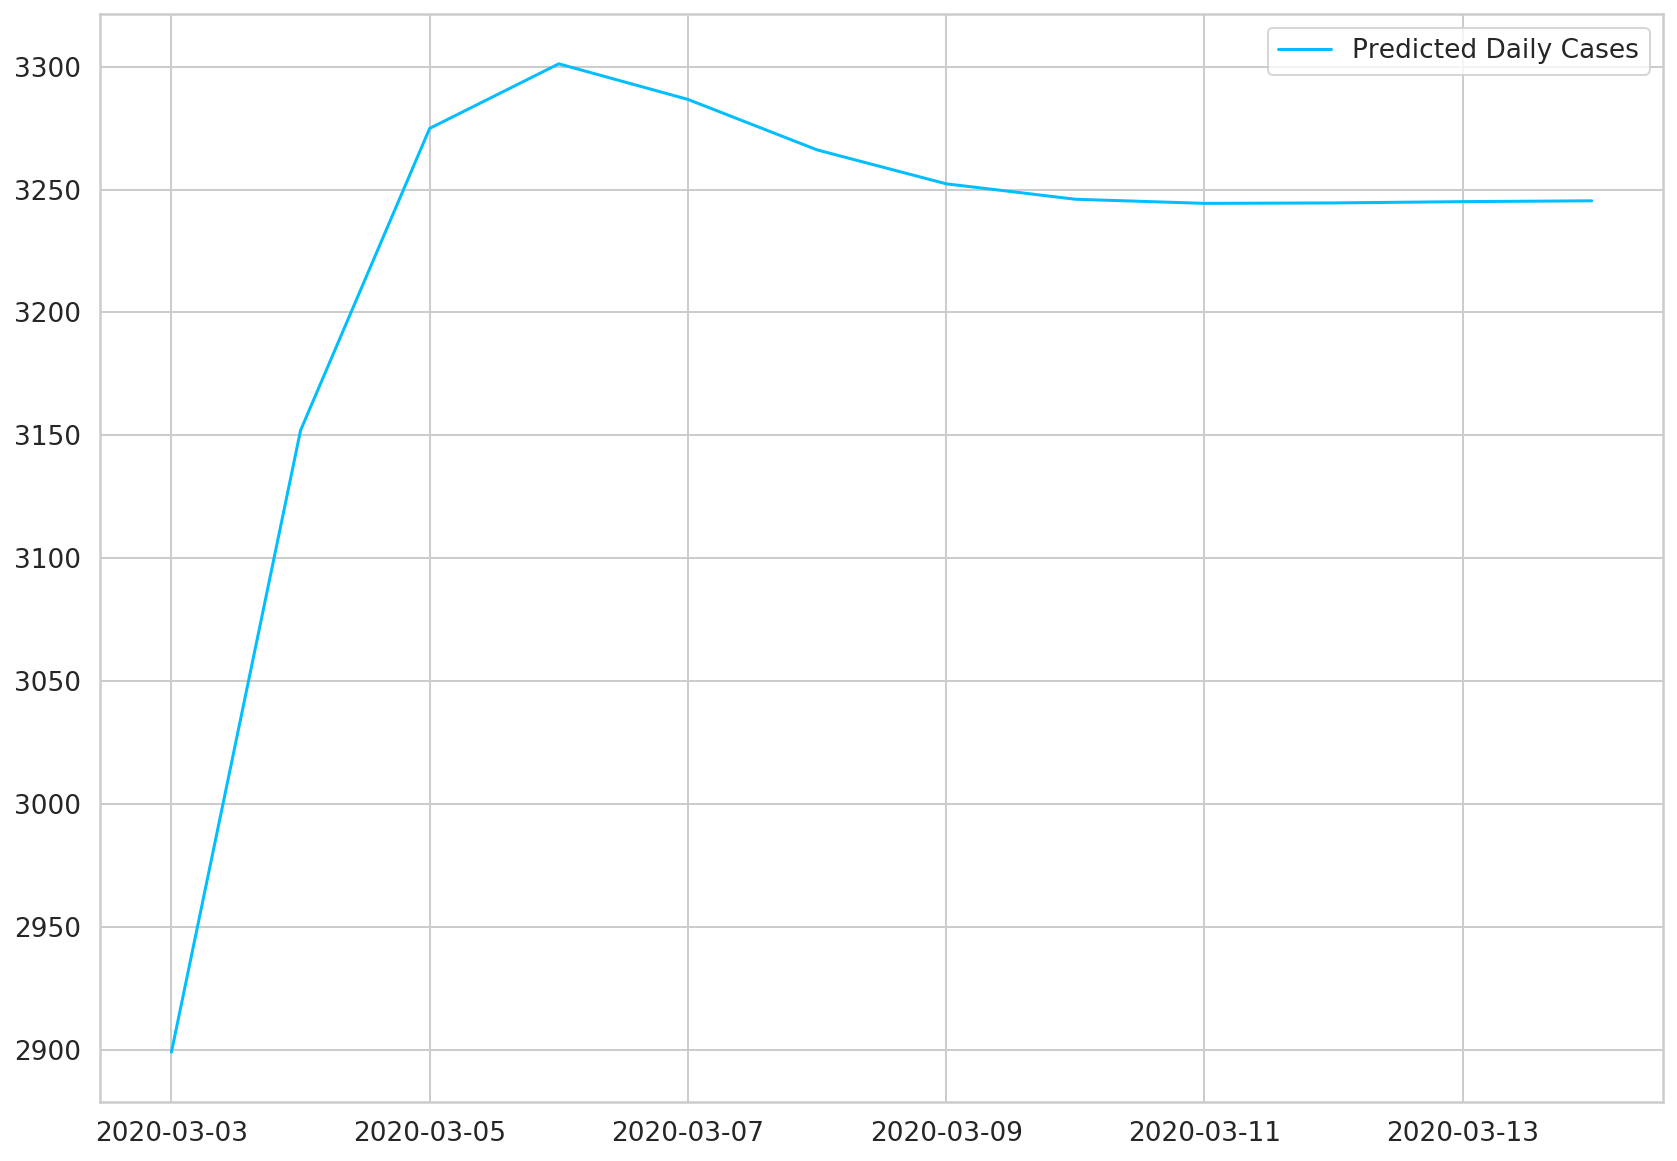

In [0]:
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

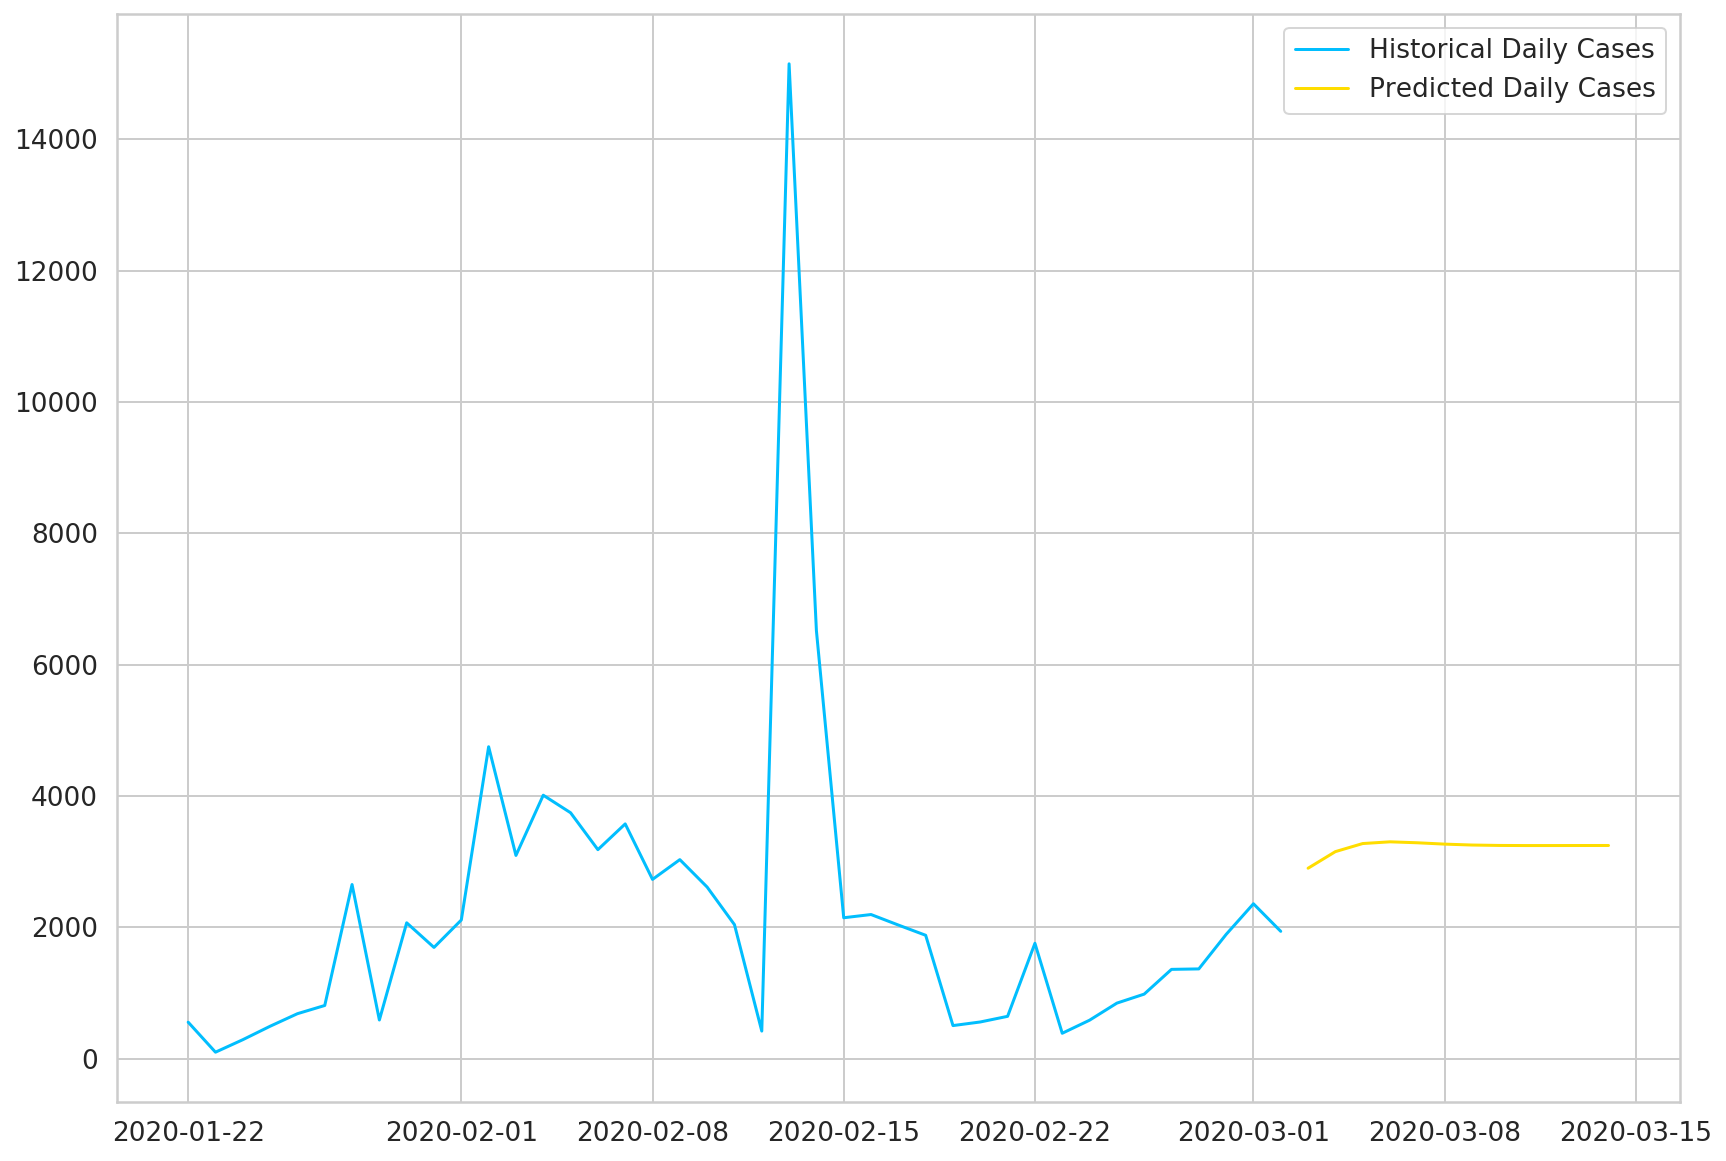

In [0]:
plt.plot(daily_cases, label='Historical Daily Cases')
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

## References

- [Sequence Models PyTorch Tutorial](https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html)
- [LSTM for time series prediction](https://towardsdatascience.com/lstm-for-time-series-prediction-de8aeb26f2ca)
- [Time Series Prediction using LSTM with PyTorch in Python](https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/)
- [Stateful LSTM in Keras](https://philipperemy.github.io/keras-stateful-lstm/)
- [LSTMs for Time Series in PyTorch](https://www.jessicayung.com/lstms-for-time-series-in-pytorch/)
- [Novel Coronavirus (COVID-19) Cases, provided by JHU CSSE](https://github.com/CSSEGISandData/COVID-19)
- [covid-19-analysis](https://github.com/AaronWard/covid-19-analysis)
- [How does Coronavirus compare to Ebola, SARS, etc?](https://www.youtube.com/watch?v=6dDD2tHWWnU)
- [Worldometer COVID-19 Coronavirus Outbreak](https://www.worldometers.info/coronavirus/)
- [How contagious is the Wuhan Coronavirus? (Ro)](https://www.worldometers.info/coronavirus/#repro)
- [Systemic Risk of Pandemic via Novel Pathogens - Coronavirus: A Note](https://www.academia.edu/41743064/Systemic_Risk_of_Pandemic_via_Novel_Pathogens_-_Coronavirus_A_Note)
- [Statistical Consequences of Fat Tails: Real World Preasymptotics, Epistemology, and Applications](https://www.researchers.one/article/2020-01-21)
